In [ ]:
def group_entites_by_number_of_chunks(entities):
    grouped_chunks = defaultdict(lambda: defaultdict(list))

    instance_lengths = dataset.get_instance_lengths()
    
    for entity in entities.keys():
        chunks = entities[entity]['M4:H+EL+Co+CoC']['chunks']
        num_chunks = len(chunks)
        
        for chunk_id in chunks:
            length = instance_lengths[int(chunk_id)]
            bucket_length = 2 ** math.ceil(math.log2(length))
            grouped_chunks[num_chunks][entity].append((chunk_id, bucket_length))
    
    # Optional: convert defaultdict to dict
    grouped_chunks = {k: dict(v) for k, v in grouped_chunks.items()}
    
    # Display grouped results
    for num_chunks, entity_dict in sorted(grouped_chunks.items()):
        print(f"\n=== Entities with {num_chunks} chunks ({len(entity_dict)} entities) ===")
        for entity, chunks in entity_dict.items():
            print(f"  Entity: {entity}")
            print(f"    Chunks: {chunks}")
    
    return grouped_chunks

In [ ]:
grouped_chunks = group_entites_by_number_of_chunks(rare_entities)

In [ ]:
import random

def sort_entities_chunks(entities_chunks, strategy={"inter": "largest", "intra": "largest"}):
    def sort_chunks(chunks, how):
        if how == "largest":
            return sorted(chunks, key=lambda x: x[1], reverse=True)
        elif how == "smallest":
            return sorted(chunks, key=lambda x: x[1])
        elif how == "random":
            shuffled = chunks[:]
            random.shuffle(shuffled)
            return shuffled
        elif how == "alternate":
            sorted_chunks = sorted(chunks, key=lambda x: x[1], reverse=True)
            result = []
            while sorted_chunks:
                result.append(sorted_chunks.pop(0))  # largest
                if sorted_chunks:
                    result.append(sorted_chunks.pop(-1))  # smallest
            return result
        elif how == "average":
            return sorted(chunks, key=lambda x: x[1], reverse=True)
        else:
            raise ValueError(f"Unknown intra-entity sort strategy: {how}")

    # Step 1: sort intra-entity chunks
    sorted_chunks_per_entity = {
        entity_id: sort_chunks(chunks, strategy["intra"])
        for entity_id, chunks in entities_chunks.items()
    }

    # Step 2: inter-entity sorting
    if strategy["inter"] == "random":
        entity_items = list(sorted_chunks_per_entity.items())
        random.shuffle(entity_items)

    elif strategy["inter"] == "largest":
        entity_items = sorted(
            sorted_chunks_per_entity.items(),
            key=lambda item: [chunk[1] for chunk in item[1]],
            reverse=True
        )

    elif strategy["inter"] == "smallest":
        entity_items = sorted(
            sorted_chunks_per_entity.items(),
            key=lambda item: [chunk[1] for chunk in item[1]]
        )

    elif strategy["inter"] == "average":
        entity_items = sorted(
            sorted_chunks_per_entity.items(),
            key=lambda item: sum(chunk[1] for chunk in item[1]) / len(item[1]) if item[1] else 0,
            reverse=True
        )

    elif strategy["inter"] == "alternate":
        # Sort by max chunk size descending
        sorted_entities = sorted(
            sorted_chunks_per_entity.items(),
            key=lambda item: item[1][0][1] if item[1] else 0,
            reverse=True
        )
        # Alternate: largest, smallest, next-largest, next-smallest, ...
        left = 0
        right = len(sorted_entities) - 1
        alternated = []
        toggle = True
        while left <= right:
            if toggle:
                alternated.append(sorted_entities[left])
                left += 1
            else:
                alternated.append(sorted_entities[right])
                right -= 1
            toggle = not toggle
        entity_items = alternated

    else:
        raise ValueError(f"Unknown inter-entity sort strategy: {strategy['inter']}")

    return dict(entity_items)


In [ ]:
sorted_entities = {}
for num_chunks, chunks in grouped_chunks.items():
    sorted_entities[num_chunks] = sort_entities_chunks(chunks, {"inter": "alternate", "intra": "alternate"})

In [ ]:
def determine_batch_size(max_chunk):
    if max_chunk == 2048:
        return 16
    elif max_chunk == 1024:
        return 32
    elif max_chunk == 512:
        return 64
    elif max_chunk == 256:
        return 128
    elif max_chunk == 128:
        return 256
    else:
        return float('inf')  # all remaining


def build_mega_batches(entities_sorted):
    entity_items = list(entities_sorted.items())
    i = 0
    mega_batches = []

    while i < len(entity_items):
        lookahead = entity_items[i:i+16]
        if not lookahead:
            break

        max_chunk_size = max(chunk[1] for _, chunks in lookahead for chunk in chunks)
        batch_size = determine_batch_size(max_chunk_size)

        mega_batch = dict(entity_items[i:i+batch_size])
        mega_batches.append(mega_batch)
        i += batch_size

    return mega_batches


def slice_mega_batch(mega_batch):
    # Get max number of chunks among entities
    max_chunks = max(len(chunks) for chunks in mega_batch.values())
    
    # Slice by index across entities
    sliced_batches = []
    for i in range(max_chunks):
        batch = {}
        for entity_id, chunks in mega_batch.items():
            if i < len(chunks):
                batch[entity_id] = chunks[i]
        sliced_batches.append(batch)
    return sliced_batches


In [ ]:
def run_sorting_experiment(entities_chunks):
    from itertools import product

    strategies = ["largest", "smallest", "average", "random", "alternate"]
    results = []

    for inter, intra in product(strategies, repeat=2):
        sorted_entities = sort_entities_chunks(
            entities_chunks,
            strategy={"inter": inter, "intra": intra}
        )

        mega_batches = build_mega_batches(sorted_entities)

        all_batches = []
        for mega_batch in mega_batches:
            sliced_batches = slice_mega_batch(mega_batch)
            all_batches.extend(sliced_batches)

        batch_sizes = [sum(chunk[1] for chunk in batch.values()) for batch in all_batches]
        total_batches = len(batch_sizes)
        batches_32768 = sum(1 for size in batch_sizes if size == 32768)
        batches_smaller = total_batches - batches_32768
        portion_32768 = batches_32768 / total_batches if total_batches > 0 else 0
        portion_smaller = batches_smaller / total_batches if total_batches > 0 else 0

        results.append({
            "inter": inter,
            "intra": intra,
            "total_batches": total_batches,
            "32768_batches": batches_32768,
            "smaller_batches": batches_smaller,
            "portion_32768": portion_32768,
            "portion_smaller": portion_smaller,
        })

    # Sort by descending number of full batches
    results_sorted_by_full = sorted(results, key=lambda x: (-x["32768_batches"], x["smaller_batches"]))

    # Best combination
    best = results_sorted_by_full[0]

    print("\n=== Top Strategy by Full Batches ===")
    print(
        f"inter={best['inter']:>9}, intra={best['intra']:>9} | "
        f"Total: {best['total_batches']:4}, "
        f"Full: {best['32768_batches']:4} ({best['portion_32768']:.2%}), "
        f"Small: {best['smaller_batches']:4} ({best['portion_smaller']:.2%})"
    )

    return best, results


In [ ]:
for num_chunks, chunks in grouped_chunks.items():
    print(f"=== num_chunks = {num_chunks} ===")
    run_sorting_experiment(chunks)

In [ ]:
from typing import Dict, List, Tuple

def build_batches_best_fit_linear(entities_chunks: Dict[str, List[Tuple[str, int]]], global_batch_size: int) -> List[Dict[str, Tuple[str, int]]]:
    # Preprocess: sort chunks descending per entity by size
    entities_sorted = {
        entity_id: sorted(chunks, key=lambda x: x[1], reverse=True)
        for entity_id, chunks in entities_chunks.items()
    }

    used_indices = {entity_id: 0 for entity_id in entities_chunks}
    total_chunks = sum(len(chunks) for chunks in entities_chunks.values())
    used_chunks = 0
    batches = []

    while used_chunks < total_chunks:
        batch = {}
        current_size = 0
        candidates = []

        # Gather best candidates (next unused chunk) per entity
        for entity_id, chunks in entities_sorted.items():
            idx = used_indices[entity_id]
            if idx < len(chunks):
                chunk_id, chunk_size = chunks[idx]
                if chunk_size + current_size <= global_batch_size:
                    candidates.append((chunk_size, entity_id, idx, chunk_id))

        # Sort candidates descending to prefer largest fitting chunks
        candidates.sort(reverse=True)

        for chunk_size, entity_id, idx, chunk_id in candidates:
            if used_indices[entity_id] != idx:
                continue  # already used by another batch iteration
            if current_size + chunk_size <= global_batch_size:
                batch[entity_id] = (chunk_id, chunk_size)
                current_size += chunk_size
                used_indices[entity_id] += 1
                used_chunks += 1

        if batch:
            batches.append(batch)
        else:
            break  # No more valid chunks to use

    return batches

In [ ]:
all_batches = {}
global_batch_size = 32768
for num_chunks, entites_chunks in grouped_chunks.items():
    batches = build_batches_best_fit_linear(entites_chunks, global_batch_size)
    all_batches[num_chunks] = batches

In [ ]:
def print_entity_batch_positions(batches):
    # Map entity_id -> list of batch indices where its chunks appear (in order)
    entity_batches = {}

    for batch_idx, batch in enumerate(batches):
        for entity_id in batch:
            entity_batches.setdefault(entity_id, []).append(batch_idx)

    # Print results
    for entity_id, batch_indices in entity_batches.items():
        print(f"Entity '{entity_id}' chunks appear in batches: {batch_indices}")

In [ ]:
for num_chunks, batches in all_batches.items():
    print_entity_batch_positions(batches)

In [ ]:
def validate_batches(batches, entities_chunks, global_batch_size):
    errors = []
    all_chunks_used = {entity: [] for entity in entities_chunks}

    for i, batch in enumerate(batches):
        # 1. Check batch size (sum the sizes from the tuples)
        total_size = sum(chunk_tuple[1] for chunk_tuple in batch.values())
        if total_size > global_batch_size:
            errors.append(f"Batch {i} exceeds global_batch_size ({total_size} > {global_batch_size})")

        # 2. Check for duplicate entities in batch
        if len(batch) != len(set(batch.keys())):
            errors.append(f"Batch {i} has duplicate entities")

        # 3. Track which chunks were used per entity
        for entity, chunk_tuple in batch.items():
            all_chunks_used[entity].append(chunk_tuple)

    # 4. Check that no chunk was used more than once per entity
    for entity, original_chunks in entities_chunks.items():
        used = all_chunks_used[entity]
        if sorted(used) != sorted(original_chunks[:len(used)]):
            # Note: this assumes we use each chunk exactly once, and none more than once
            remaining = list(original_chunks)
            for u in used:
                if u in remaining:
                    remaining.remove(u)
                else:
                    errors.append(f"Entity {entity} has duplicate or invalid chunk {u} used")
                    break

    if not errors:
        print("✅ All batches are valid!")
    else:
        print("❌ Found the following issues:")
        for err in errors:
            print("-", err)


In [ ]:
for num_chunks, batches in all_batches.items():
    print(f"=== Validating batches for entities with {num_chunks} chunks")
    validate_batches(batches, grouped_chunks[num_chunks], global_batch_size)

In [ ]:
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def plot_batch_summary_with_small_batch_sizes(
    batches_by_num_chunks: Dict[int, List[Dict[str, Tuple[str, int]]]],
    global_batch_size: int,
    small_batch_threshold_ratio: float = 0.8
):
    num_groups = len(batches_by_num_chunks)
    cols = 3
    rows = (num_groups + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    axes = axes.flatten()

    total_batches_global = 0
    total_small_batches_global = 0

    for ax_idx, (num_chunks, batches) in enumerate(sorted(batches_by_num_chunks.items())):
        full_batches = 0
        small_batches = 0
        small_batch_sizes = []

        for batch in batches:
            # Sum the sizes from the tuples (second element of each tuple)
            batch_size = sum(chunk_tuple[1] for chunk_tuple in batch.values())
            if batch_size >= global_batch_size * small_batch_threshold_ratio:
                full_batches += 1
            else:
                small_batches += 1
                small_batch_sizes.append(batch_size)

        total_batches = full_batches + small_batches
        if total_batches == 0:
            continue

        total_batches_global += total_batches
        total_small_batches_global += small_batches

        # Donut chart
        ax = axes[ax_idx]
        ax.set_title(f'Chunks per Entity = {num_chunks}', fontsize=10)
        sizes = [full_batches, small_batches]
        labels = ['Full Batches', 'Small Batches']
        colors = ['#4CAF50', '#FFC107']

        wedges, texts, autotexts = ax.pie(
            sizes,
            labels=labels,
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
            wedgeprops=dict(width=0.3),
            textprops={'fontsize': 9}
        )

        # Store small batch sizes for separate plotting
        if hasattr(plot_batch_summary_with_small_batch_sizes, '_all_small_batch_data'):
            plot_batch_summary_with_small_batch_sizes._all_small_batch_data.append((num_chunks, small_batch_sizes))
        else:
            plot_batch_summary_with_small_batch_sizes._all_small_batch_data = [(num_chunks, small_batch_sizes)]

        # Local summary text
        percent_small = (small_batches / total_batches) * 100
        summary_text = (
            f'Total batches: {total_batches}\n'
            f'Smaller batches: {small_batches} ({percent_small:.1f}%)'
        )
        ax.text(0, -1.3, summary_text, ha='center', fontsize=9)

    # Remove unused subplots
    for i in range(ax_idx + 1, len(axes)):
        fig.delaxes(axes[i])

    # Global summary
    if total_batches_global > 0:
        global_percent_small = (total_small_batches_global / total_batches_global) * 100

    plt.tight_layout()
    plt.suptitle(f'Batch Statistics: Total number of batches: {total_batches_global}, Smaller batches: {total_small_batches_global} ({global_percent_small:.1f}%)', fontsize=16)
    plt.subplots_adjust(top=0.9, bottom=0.12)
    plt.show()

    # Create separate plot for small batch size distributions
    plot_small_batch_distributions(global_batch_size, small_batch_threshold_ratio)

def plot_small_batch_distributions(global_batch_size: int, small_batch_threshold_ratio: float):
    """Plot separate histograms for small batch size distributions by num_chunks."""
    if not hasattr(plot_batch_summary_with_small_batch_sizes, '_all_small_batch_data'):
        return
    
    data = plot_batch_summary_with_small_batch_sizes._all_small_batch_data
    # Filter out empty data
    data = [(num_chunks, sizes) for num_chunks, sizes in data if sizes]
    
    if not data:
        print("No small batches to display distributions for.")
        return
    
    num_groups = len(data)
    cols = 3
    rows = (num_groups + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    if num_groups == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (num_chunks, small_batch_sizes) in enumerate(data):
        ax = axes[idx]
        
        # Create histogram
        ax.hist(small_batch_sizes, bins=max(6, len(small_batch_sizes)//3), 
                color='#FFC107', edgecolor='black', alpha=0.7)
        
        # Add threshold line
        threshold_line = global_batch_size * small_batch_threshold_ratio
        ax.axvline(threshold_line, color='red', linestyle='--', 
                  label=f'Threshold ({small_batch_threshold_ratio*100:.0f}%)')
        
        # Formatting
        ax.set_title(f'Small Batch Sizes (Chunks per Entity = {num_chunks})', fontsize=11)
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Set reasonable x-axis limits
        ax.set_xlim(0, threshold_line * 1.1)
        
        # Add statistics text
        mean_size = sum(small_batch_sizes) / len(small_batch_sizes)
        stats_text = f'Count: {len(small_batch_sizes)}\nMean: {mean_size:.0f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Remove unused subplots
    for i in range(len(data), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.suptitle('Distribution of Small Batch Sizes by Chunks per Entity', fontsize=14)
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Clear the stored data for next run
    delattr(plot_batch_summary_with_small_batch_sizes, '_all_small_batch_data')

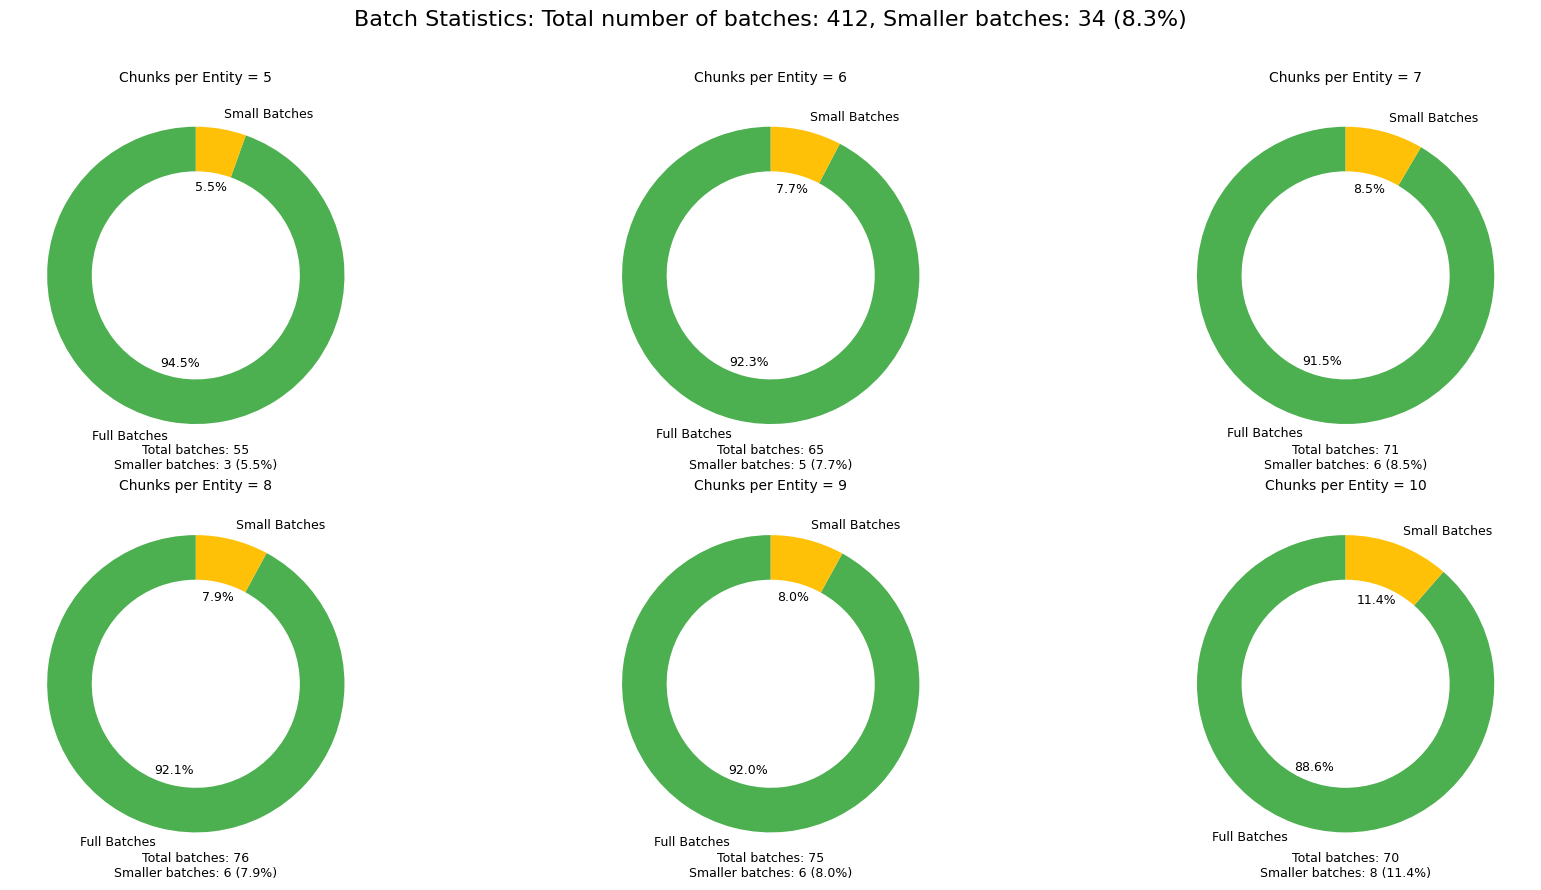

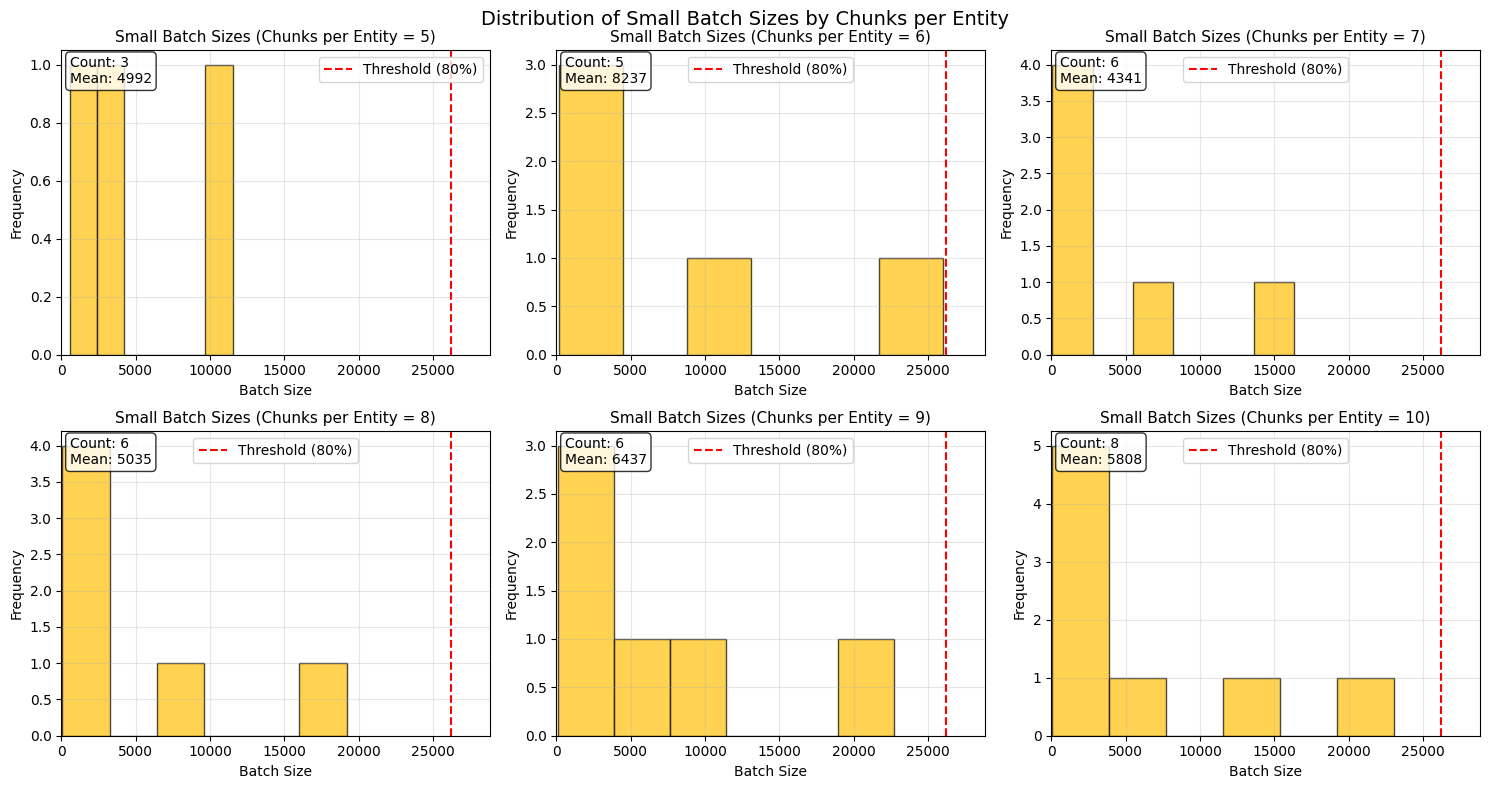

In [ ]:
plot_batch_summary_with_small_batch_sizes(all_batches, 32768)